# causalBootstrapping: Tutorial 01

A series of tutorials demonstrating the use of the causalBootstrapping library.

### Backdoor

This tutorial mainly focuses on illustrating the use of backdoor causal bootstrapping interfaces: `backdoor_simple()` and `backdoor_simu()`.

In [1]:
import causalBootstrapping as cb
from distEst_lib import MultivarContiDistributionEstimator
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

#### Discrete intervention - using backdoor_simple()

In [2]:
# Read demo data
testdata_dir = "../test_data/frontdoor_discY_contZ_contX_discU/"
X_train = pd.read_csv(testdata_dir + "X_train.csv")
Y_train = pd.read_csv(testdata_dir + "Y_train.csv")
U_train = pd.read_csv(testdata_dir + "U_train.csv")

In [3]:
# Re-formulate the data
X_train = np.array(X_train)
Y_train = np.array(Y_train)
U_train = np.array(U_train)

cause_data = {"Y": Y_train}
effect_data = {"X": X_train}
confounder_data = {"U": U_train}

In [4]:
# Estimate the desired distributions
n_bins_yu = [0, 0, 0]
n_bins_u = [0, 0]
joint_yu_data = np.concatenate((Y_train.reshape(-1,1), U_train), axis = 1)

dist_estimator_yu = MultivarContiDistributionEstimator(data_fit=joint_yu_data, n_bins = n_bins_yu)
pdf_yu, pyu = dist_estimator_yu.fit_histogram()
dist_estimator_u = MultivarContiDistributionEstimator(data_fit=U_train, n_bins = n_bins_u)
pdf_u, pu = dist_estimator_u.fit_histogram()

In [5]:
# Construct the distribution mapping dict
dist_map = {tuple(sorted(['Y', 'U'])): lambda Y, U: pdf_yu([Y,U]),
            tuple(['U']): lambda U: pdf_u(U)}

In [6]:
# bootstrap the dataset given the backdoor scenario
cb_data = cb.backdoor_simple(cause_data, effect_data, confounder_data, dist_map)

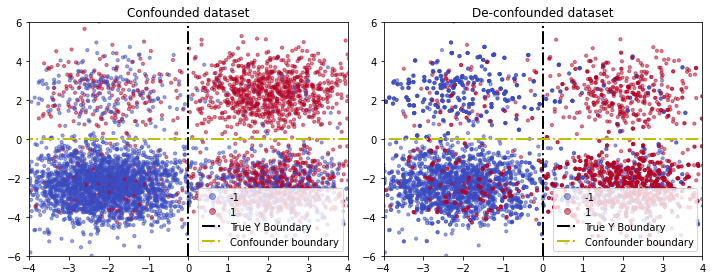

In [7]:
## Compare the boostrapping results with the original dataset
# The original confounded dataset
fig,axs=plt.subplots(1, 2 , figsize=(10,4))
scatter = axs[0].scatter(x= np.array(X_train)[:,0], y = np.array(X_train)[:,1], c = np.array(Y_train), s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter1, labels_scatter1 = scatter.legend_elements(prop="colors")

true_b1 = axs[0].plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder1 = axs[0].plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")

axs[0].legend(handles=handles_scatter1+true_b1+confounder1, labels=['-1','1','True Y Boundary', 'Confounder boundary'], loc='lower right')
axs[0].set_xlim(-4,4)
axs[0].set_ylim(-6,6)
axs[0].set_title("Confounded dataset")

# The bootstrapped de-confounded dataset
scatter = axs[1].scatter(x= np.array(cb_data["X"])[:,0], y = np.array(cb_data["X"])[:,1], c = np.array(cb_data["intv_Y"]),  s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter2, labels_scatter2 = scatter.legend_elements(prop="colors")

true_b2 = axs[1].plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder2 = axs[1].plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")

axs[1].legend(handles=handles_scatter2+true_b2+confounder2, labels=['-1','1','True Y Boundary', 'Confounder boundary'], loc='lower right')
axs[1].set_xlim(-4,4)
axs[1].set_ylim(-6,6)
axs[1].set_title("De-confounded dataset")

plt.tight_layout()
plt.show()

In [8]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=5)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=5)
clf_cb.fit(cb_data['X'], cb_data['intv_Y'].reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir +  "X_test.csv")
Y_test = pd.read_csv(testdata_dir +  "Y_test.csv")
X_test = np.array(X_test)
Y_test = np.array(Y_test)

y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.63      0.80      0.71       386
           2       0.85      0.71      0.77       614

    accuracy                           0.74      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.77      0.74      0.75      1000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       386
           2       0.89      0.82      0.85       614

    accuracy                           0.83      1000
   macro avg       0.82      0.83      0.82      1000
weighted avg       0.83      0.83      0.83      1000



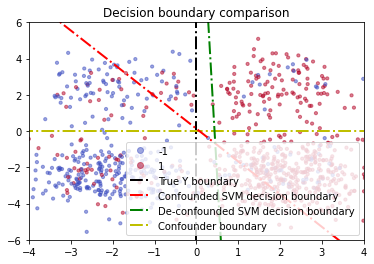

In [9]:
# Compare models' decision boundaries
weight_conf = clf_conf.coef_[0]
bias_conf = clf_conf.intercept_[0]
k_conf = -weight_conf[0] / weight_conf[1]
b_conf = -bias_conf / weight_conf[1]
x_conf = np.linspace(-4, 4, 100)
decison_boundary_conf = k_conf * x_conf + b_conf

weight_deconf = clf_cb.coef_[0]
bias_deconf = clf_cb.intercept_[0]
k_deconf = -weight_deconf[0] / weight_deconf[1]
b_deconf = -bias_deconf / weight_deconf[1]
x_deconf = np.linspace(-4, 4, 100)
decison_boundary_deconf = k_deconf * x_deconf + b_deconf

fig,ax=plt.subplots()
scatter = ax.scatter(x= X_test[:,0], y = X_test[:,1], c = Y_test, s = 10, cmap='coolwarm', alpha = 0.5)
handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")

plt.xlim(-4,4)
plt.ylim(-6,6)
x_ = np.linspace(-4, 4, 100)

true_b = plt.plot([0, 0], [-6, 6], '-.k', linewidth=2, label="True boundary")
confounder = plt.plot([-6,6], [0,0], '-.y', linewidth = 2, label = "Confounder boundary")
clf_b_conf = plt.plot(x_, decison_boundary_conf, '-.r', linewidth = 2, label= 'Confounded SVM decision boundary')
clf_b_deconf = plt.plot(x_, decison_boundary_deconf, '-.g', linewidth = 2, label= 'De-confounded SVM decision boundary')

ax.legend(handles=handles_scatter+true_b+clf_b_conf+clf_b_deconf+confounder, labels=['-1','1','True Y boundary','Confounded SVM decision boundary', 'De-confounded SVM decision boundary', 'Confounder boundary'], loc='lower right')

plt.title('Decision boundary comparison')
plt.show()

#### Continous intervention - using backdoor_simu()

In [10]:
# Read demo data
testdata_dir = "../test_data/backdoor_contY_contX_contU/"
X_train = pd.read_csv(testdata_dir + "X_train.csv")
Y_train = pd.read_csv(testdata_dir + "Y_train.csv")
U_train = pd.read_csv(testdata_dir + "U_train.csv")

In [11]:
# Re-formulate the data
X_train = np.array(X_train)
Y_train = np.array(Y_train)
U_train = np.array(U_train)

cause_data = {"Y": Y_train}
effect_data = {"X": X_train}
confounder_data = {"U": U_train}
N = Y_train.shape[0]

In [12]:
# Estimate the desired distributions
joint_yu_data = np.concatenate((Y_train.reshape(-1,1), U_train), axis = 1)
dist_est_bin_num = 50
n_bins_yu = [dist_est_bin_num,dist_est_bin_num]
n_bins_u = [dist_est_bin_num]

dist_estimator_yu = MultivarContiDistributionEstimator(data_fit=joint_yu_data, n_bins = n_bins_yu)
pdf_yu, pyu = dist_estimator_yu.fit_histogram()
dist_estimator_u = MultivarContiDistributionEstimator(data_fit=U_train, n_bins = n_bins_u)
pdf_u, pu = dist_estimator_u.fit_histogram()

In [13]:
# Construct the distribution mapping dict
dist_map = {tuple(sorted(['Y', 'U'])): lambda Y, U: pdf_yu([Y,U]),
            tuple(['U']): lambda U: pdf_u(U)}

In [14]:
# Set simulated interventions and bootstrap the data
intv_intval_num = 20
kernel_width = 0.1
Y_interv_values = np.linspace(np.min(Y_train), np.max(Y_train), intv_intval_num)

cb_data_simu = {}
for i, interv_value in enumerate(Y_interv_values):
    cb_data = cb.backdoor_simu(cause_data = cause_data, 
                               effect_data = effect_data, 
                               confounder_data = confounder_data, 
                               dist_map = dist_map, 
                               intv_value = [interv_value for i in range(N)], 
                               n_sample = int(N/intv_intval_num), 
                               kernel_intv = lambda Y, intv_Y: norm.pdf(Y-intv_Y, 0, kernel_width))
    for key in cb_data:
        if i == 0:
            cb_data_simu[key] = cb_data[key]
        else:
            cb_data_simu[key] = np.vstack((cb_data_simu[key], cb_data[key]))

In [15]:
## Train two linear support vector machines using confounded and de-confounded datasets
reg_cb = svm.SVR(kernel = "linear", C=5)
reg_cb.fit(cb_data_simu['X'], cb_data_simu['intv_Y'].reshape(-1))

reg_conf = svm.SVR(kernel = "linear", C=5)
reg_conf.fit(X_train, Y_train.reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir + "X_test.csv")
Y_test = pd.read_csv(testdata_dir + "Y_test.csv")
X_test = np.array(X_test)
Y_test = np.array(Y_test)

pred_cb = reg_cb.predict(X_test)
mse_cb = mean_squared_error(Y_test, pred_cb)
mae_cb = mean_absolute_error(Y_test, pred_cb)
mape_cb = mean_absolute_percentage_error(Y_test, pred_cb)
r2_cb = r2_score(Y_test, pred_cb)
print("Report of deconfonded model:")
print("MSE: %.4f" %(mse_cb))
print("MAE: %.4f" %(mae_cb))
print("MAPE: %.4f" %(mape_cb))
print("R-squared: %.4f" %(r2_cb))

pred_conf = reg_conf.predict(X_test)
mse_conf = mean_squared_error(Y_test, pred_conf)
mae_conf = mean_absolute_error(Y_test, pred_conf)
mape_conf = mean_absolute_percentage_error(Y_test, pred_conf)
r2_conf = r2_score(Y_test, pred_conf)
print("Report of confonded model:")
print("MSE: %.4f" %(mse_conf))
print("MAE: %.4f" %(mae_conf))
print("MAPE: %.4f" %(mape_conf))
print("R-squared: %.4f" %(r2_conf))

Report of deconfonded model:
MSE: 0.4404
MAE: 0.5245
MAPE: 1.9500
R-squared: 0.5342
Report of confonded model:
MSE: 0.6239
MAE: 0.6172
MAPE: 1.8170
R-squared: 0.3401


In [16]:
# Compare models' regression hyperplain
%matplotlib qt5
x_grid, y_grid = np.meshgrid(np.linspace(-5,55, num=100), np.linspace(-10,7.5, num=100))
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]
z_grid_cb = reg_cb.predict(grid_points)
z_grid_cb = z_grid_cb.reshape(x_grid.shape)
z_grid_conf = reg_conf.predict(grid_points)
z_grid_conf = z_grid_conf.reshape(x_grid.shape)

# Plot the unconfounded test data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], Y_test, color='blue', marker='o', s = 20, alpha = 0.7)
# Plot the regression hyperplain
surf1 = ax.plot_surface(x_grid, y_grid, z_grid_cb, color='orange', alpha=0.5)
surf2 = ax.plot_surface(x_grid, y_grid, z_grid_conf, color='green', alpha=0.5)
surf1._facecolors2d = surf1._facecolors
surf1._edgecolors2d = surf1._edgecolors
surf2._facecolors2d = surf2._facecolors
surf2._edgecolors2d = surf2._edgecolors
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')
ax.legend(["Unconfounded test data", 
           "deconfounded regression surface", 
           "confounded regression surface"])
plt.title("Regression hyperplain & Unconfounded test data")
plt.tight_layout()
plt.show()

# Plot the deconfounded and confounded training data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(cb_data_simu["X"][:,0], cb_data_simu["X"][:,1], cb_data_simu["intv_Y"], color='red', marker='x', s = 10, alpha = 0.4)
ax.scatter(X_train[:,0], X_train[:,1], Y_train, color='green', marker='o', s = 10, alpha = 0.4)
# Plot the regression hyperplain
surf1 = ax.plot_surface(x_grid, y_grid, z_grid_cb, color='orange', alpha=0.5)
surf2 = ax.plot_surface(x_grid, y_grid, z_grid_conf, color='green', alpha=0.5)
surf1._facecolors2d = surf1._facecolors
surf1._edgecolors2d = surf1._edgecolors
surf2._facecolors2d = surf2._facecolors
surf2._edgecolors2d = surf2._edgecolors
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Target')
ax.legend(["Deconfounded training data", 
           "Confounded training data", 
           "deconfounded regression surface", 
           "confounded regression surface"])
plt.title("Regression hyperplain & Unconfounded test data")
plt.tight_layout()
plt.show()